# COMP90051 Project 2
**Name:** *enter your name here*

**Student ID:** *your id here*

In [304]:
# You can add additional imports here
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
# Additional imports
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier
from numpy import mean
from random import randrange
from numpy import std
import time
from copy import copy
from scipy.stats import entropy
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")




## 0. Loading the dataset

In [2]:
# do not edit this cell
# load the data files (download from the LMS)
embedded_images = np.load('images.npy')
labels = np.load('labels.npy')

# split into pool & testing
X_pool, X_test, y_pool, y_test = train_test_split(embedded_images, labels, 
                                                  test_size=0.5, random_state=1234, shuffle=True)

# sample a seed set
np.random.seed(1234)
label2id = defaultdict(list)
for i, label in enumerate(y_pool):
    label2id[label].append(i)
seed_set = []
for label, ids in label2id.items():
    seed_set.extend(np.random.choice(ids, size=10, replace=False))

In [285]:
myset = set(y_pool)
Label_List =[] 
Label_List = list(myset)
le = preprocessing.LabelEncoder()
le.fit(Label_List)
list(le.classes_)

#le.transform(['Alphabet_of_the_Magi','Anglo-Saxon_Futhorc','Arcadian'])


['Alphabet_of_the_Magi',
 'Anglo-Saxon_Futhorc',
 'Arcadian',
 'Armenian',
 'Asomtavruli_(Georgian)',
 'Balinese',
 'Bengali',
 'Blackfoot_(Canadian_Aboriginal_Syllabics)',
 'Braille',
 'Burmese_(Myanmar)',
 'Cyrillic',
 'Early_Aramaic',
 'Futurama',
 'Grantha',
 'Greek',
 'Gujarati',
 'Hebrew',
 'Inuktitut_(Canadian_Aboriginal_Syllabics)',
 'Japanese_(hiragana)',
 'Japanese_(katakana)',
 'Korean',
 'Latin',
 'Malay_(Jawi_-_Arabic)',
 'Mkhedruli_(Georgian)',
 'N_Ko',
 'Ojibwe_(Canadian_Aboriginal_Syllabics)',
 'Sanskrit',
 'Syriac_(Estrangelo)',
 'Tagalog',
 'Tifinagh']

In [302]:
#Helper Function
# 1 - Print Accuracy Score Of Model  
def printAccuracyScore(modelName,score):
    print(modelName, "Accuracy: {}".format(score))

#2 -  Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
	sample = list()
	n_sample = round(len(dataset) * ratio)
	while len(sample) < n_sample:
		index = randrange(len(dataset))
		sample.append(dataset[index])
	return sample 
#3 -  Encoding y_lables
def encode_Y(y_pool):
    # myset = set(y_pool)
    # Label_List=[]
    # Label_List = list(myset)
    le= preprocessing.LabelEncoder()
    le.fit(y_pool)
    List_of_encode= le.transform(y_pool)
    return  List_of_encode 
#  #4 - Get Code    
# def encoding(labelEncodedList,y_labelList):
# 	List_of_encode= labelEncodedList.transform(y_labelList)
# 	return List_of_encode   
    

## 1. Applying logistic regression

In [237]:
def train_logistic_regression(X, y, **args):
    """
    Train a logistic regression model on dataset (X, y) and return trained model.
    X: matrix of real values, size n x d
    y: vector of string labels, size n
    args: optional arguments e.g., for hyper-parameters
    """
    # your code here
    # run logistic regression model
    # NOTE = Find Best parameters  #Best: 0.302222 using {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
    start = time.time()
    
    log_reg = LogisticRegression(multi_class='multinomial',C=0.01,penalty='l2',solver='lbfgs')
    model = log_reg.fit(X, y)

    stop = time.time()
    print(f"Training time: {stop - start}s")

    return model


In [238]:
def evaluate_logistic_regression_accuracy(Xt, yt, model):
    """
    Apply logistic regression prediction on dataset Xt and evaluate accuracy against yt,
    returing the accuracy results as a scalar.
    Xt: matrix of real values, size m x d
    yt: vector of string labels, size m
    """
    # your code here
    y_pred = model.predict(Xt)
    score = accuracy_score(yt, y_pred)
    #print("Accuracy: {}".format(accuracy_score(yt, y_pred)))
    return score

  

In [239]:
# your code here for training, evaluating & plotting results

# Traning and Evaluation of Model (model_subset) with Subest of y_pool.

model_subset = train_logistic_regression(X_pool[seed_set],y_pool[seed_set])
score_model_subset = evaluate_logistic_regression_accuracy(X_test,y_test,model_subset)
#print("model_subset Accuracy: {}".format(score_model_subset))
printAccuracyScore("model_subset",score_model_subset)
print("\n")

# Traning and Evaluation of  Model (model_max_pool) with Max Pool 
model_max_pool = train_logistic_regression(X_pool,y_pool)
score_model_max_pool = evaluate_logistic_regression_accuracy(X_test,y_test,model_max_pool)
printAccuracyScore("model_max_pool",score_model_max_pool)

# Graphs
# Evaluation Report 




Training time: 0.7469980716705322s
model_subset Accuracy: 0.31732365145228214


Training time: 9.458997011184692s
model_max_pool Accuracy: 0.5675311203319502


## 2. Active learning framework with Random selection

In [240]:
def random_select(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a model (not used)
    returns a vector of scores of length n. Each entry reflects the priority 
    of the corresponding instance. Higher means better.
    """
    # Creating a score array using random numbers of length of X 
    scores = np.random.randint(1,len(X),len(X))
    return scores
    

In [336]:
def pool_based_active_learning(X_pool, y_pool, seed_ids,
                               train_func, select_func,
                               max_size, batch_size, **args):
    """
    Perform an active learning simulation, which starts by training on a seed set,
    then iteratively applies the selection function to rank instances in the pool,
    selects the top few instances which are included into the training set and the
    process repeats. 
        X_pool: matrix of n x d
        y_pool: vector of string labels, size n
        seed_ids: initial labelled set set, as a list of indices [0..n-1] into pool
        train_func: function which given (X, y, optional args) returns a trained model
        select_func: function which given (X, optional args) returns a sequence of scores
        max_size: stopping condition for active learning, when labelled data reaches given size
        batch_size: number of instances to be labelled in each iteration
        args: optional arguments passed to training and selection function
    returns the sequence of trained models 
    """
    trained_models =[]
    seed = copy(seed_ids)   # To avoid Pass by Refernce Update 
    i = 0 
    # 1: U = pool of unlabelled instances, {x} 
    U =  np.delete(X_pool,seed, axis=0)
    # 2: L = set of initial labelled instances, {hx,yi} 
    L = [X_pool[seed],y_pool[seed]]   # L = (x,y)  
    # 3: b = number of instances to label in each step 
    b =  batch

    # 4: for t = 1,2,...,T do 
    #for i in range(1,46):  # Loop will run from 300 to 3000 Instances
    #TODO: Test Max Size is integer or not  
    #while(len(seed) < max_size):
    while(1 < 5):
        i+=1
    # 5:  θ(t) = train(L) 
        Theta_model=train_func(L[0],L[1]) # train_ensemble returns (ensemble_model-just return 2 models,trained_logidtic_model) = theta_model
   
    # 6:  score all instances in pool, r = select(U) 
        r = select_func(U,Theta_model)  #Note Argmax Check <- ensembled_model to assign ranks to all the seedset data
        # here select_func is querybycommitee
    # 7:  for all j ∈ argmax(b,r) do 
        max_indices = np.argpartition(r,-b)[-b:]
        for j in max_indices:
    # 8:      reveal label y     
    # 9:      add hxj,yji to L
            L[0] = np.append(L[0],[X_pool[j]], axis=0)
            L[1]= np.append(L[1],y_pool[j])
            seed.append(j)
    # 10:     remove xj from U 
            U = np.delete(X_pool,seed,axis=0)   # (U,j)
             #  Calculate and report our model's accuracy.                       
    # 11:    end for 
    # 12: end for 
    # 13: return {θ(t)}T t=1
 #  Calculate and report our model's accuracy. REMOVE IT
        # model_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,Theta_model[2])
        # print('Accuracy after query {n}: {acc:0.4f}'.format(n=i, acc=model_accuracy))
    # Save our model's performance for plotting.
        trained_models.append(Theta_model)

    
    return trained_models  #model list return 



In [241]:
# Theta_model=[]
# d=[9149,7806,431,5765,3554,3550] 
# r=random_select(d,Theta_model)  #Note Argmax Check
# print(r)
# b = 2 
#     # 7:  for all j ∈ argmax(b,r) do 
# max_indices = np.argpartition(r,-b)[-b:]
# print(max_indices)
# #len(y_pool[seed_set])
# #Supress warning 


In [242]:
batch = 60
max_size = 3000
models_random = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                    train_logistic_regression, random_select, 
                                    max_size, batch)
        # model_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,Theta_model)



Training time: 1.0369811058044434s
Training time: 0.8814749717712402s
Training time: 0.7979733943939209s
Training time: 0.9069757461547852s
Training time: 0.7539963722229004s
Training time: 0.8880066871643066s
Training time: 0.9245364665985107s
Training time: 1.2960619926452637s
Training time: 0.9550082683563232s
Training time: 0.9900014400482178s
Training time: 1.304616928100586s
Training time: 1.167996883392334s
Training time: 1.1519463062286377s
Training time: 1.0459985733032227s
Training time: 1.1279988288879395s
Training time: 1.1379969120025635s
Training time: 1.208998441696167s
Training time: 1.274951696395874s
Training time: 1.3299543857574463s
Training time: 1.3819892406463623s
Training time: 1.2099711894989014s
Training time: 1.3849680423736572s
Training time: 1.2869548797607422s
Training time: 1.2049579620361328s
Training time: 1.3019981384277344s
Training time: 1.2529540061950684s
Training time: 1.273345947265625s
Training time: 1.28995680809021s
Training time: 1.5329999923

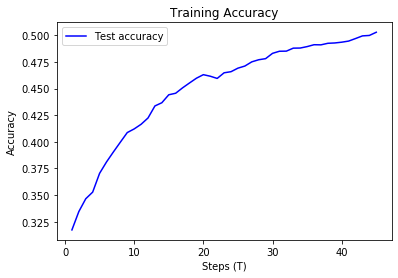

In [243]:
## your code here for evaluation of accuracy and plotting of results

evalutaion_scores=[]
for model in models_random:
     test_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,model)
     evalutaion_scores.append(test_accuracy)

iterations = range(1, len(evalutaion_scores) + 1)

plt.plot(iterations, evalutaion_scores, 'b', label='Test accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.xlabel("Steps (T)")
plt.ylabel("Accuracy")

plt.show()

# NOTE: Make Graphs and Check Evaluation Scores

## 3. Uncertainty sampling

In [244]:
def logistic_regression_entropy_select(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a discriminative model 
    P(y|x), returns a vector of n entropy values.
    """
    # 
    prob = model.predict_proba(X)
    ent  = entropy(prob,axis=1)
    return ent

    

In [245]:
models_us = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_logistic_regression, 
                                 logistic_regression_entropy_select, 
                                 max_size, batch)

Training time: 0.7659971714019775s
Training time: 0.649000883102417s
Training time: 0.7340013980865479s
Training time: 0.7835683822631836s
Training time: 0.8600137233734131s
Training time: 0.8660018444061279s
Training time: 0.8801157474517822s
Training time: 0.8989553451538086s
Training time: 1.1519966125488281s
Training time: 0.9449954032897949s
Training time: 1.0489704608917236s
Training time: 1.1719703674316406s
Training time: 1.1129987239837646s
Training time: 1.5120019912719727s
Training time: 1.208953619003296s
Training time: 1.1909701824188232s
Training time: 1.0740013122558594s
Training time: 1.1089997291564941s
Training time: 1.2119958400726318s
Training time: 1.2079529762268066s
Training time: 2.644005060195923s
Training time: 1.2909955978393555s
Training time: 1.464003562927246s
Training time: 2.1380021572113037s
Training time: 1.2581171989440918s
Training time: 1.3379485607147217s
Training time: 1.2120070457458496s
Training time: 1.3359453678131104s
Training time: 1.4240038

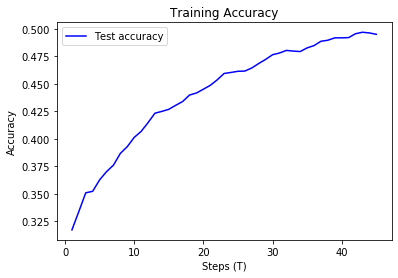

In [16]:
## your code here for evaluation of accuracy and plotting of results

evalutaion_scores=[]
for model in models_us:
     test_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,model)
     evalutaion_scores.append(test_accuracy)

iterations = range(1, len(evalutaion_scores) + 1)

plt.plot(iterations, evalutaion_scores, 'b', label='Test accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.xlabel("Steps (T)")
plt.ylabel("Accuracy")

plt.show()


## 4. Query by committee

In [ ]:
# don't forget to provide function descriptive comments, like those provided in templates above

def query_by_committee_vote_entropy(X, model, **args):
    # This model is a tuple
    # enseble model use this to assign rank to each data point using bagging
    # m = model[0]
    # num_classes = len(m[0].classes_)
    # print(num_classes)
    # C = len(m)
    # preds = []

    # for model in m:
    #     #y_out = map(int, model.predict(X))
    #     y_out =model.predict_proba(X)
    #     y_out = y_out.astype(int)
    #     #print(y_out)
    #     preds.append(np.eye(num_classes)[y_out])

    # votes = np.apply_along_axis(np.sum, 0, np.stack(preds)) // C
    # #print(votes)
    # score = np.apply_along_axis(entropy, 1, votes)
    # print(score.shape)
    #attempt two %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # m = model[0]
    # preds = []
    # vote = []
    # for model in m:
    #     y_out =model.predict(X)
    #     preds.append(y_out)
  

    # for i in range(len(preds[0])):
    #     if preds[0][1] == preds[1][i]
    #attempt two %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    mod = model[0]
    num_classes = len(mod[0].classes_)
    C= len(model[0])
    preds = []
    for model in mod:
        y_out = model.predict(X)
        preds.append(np.eye(num_classes)[y_out])

    votes = np.apply_along_axis(np.sum, 0, np.stack(preds)) / C
    return np.apply_along_axis(entropy, 1, votes)


    #return score
    

def query_by_committee_soft_vote_entropy(X, model, **args):
    mod = model[0]
    num_classes = len(mod[0].classes_)
    C= len(model[0])
    preds = []
    for model in mod:
        y_out = model.predict_proba(X)
        #print(y_out)
        preds.append(y_out)
        #print(y_out.shape)

    votes = np.apply_along_axis(np.sum, 0, np.stack(preds)) / C
    return np.apply_along_axis(entropy, 1, votes)


def query_by_committee_KL(X, model, **args):
    pass

In [324]:
def train_committee(X, y, **args):

 ensemble = list()
 log_reg_base = LogisticRegression(multi_class='multinomial',C=0.01,penalty='l2',solver='lbfgs')
 model_base = log_reg_base.fit(X, y)

# Bagging:Creating Sub Samples for Ensemble
#  X1 = subsample(X,1)
#  X2 = subsample(X,1)
#  y1 = subsample(y,1)
#  y2 = subsample(y,1)
#######################################################
 max_sample = len(X)

 encoded_list_y = encode_Y(y)

# Bagging:Creating Sub Samples for Ensemble
 #Committee member 1
 bag_clf = BaggingClassifier(
 LogisticRegression(random_state=42,multi_class='multinomial',C=0.01,penalty='l2',solver='lbfgs'), n_estimators=1,
 max_samples=max_sample, oob_score=False, bootstrap=True, random_state=42)
 C1 = bag_clf.fit(X, encoded_list_y)

 #Committee member 2
 bag_clf = BaggingClassifier(
 LogisticRegression(random_state=42,multi_class='multinomial',C=0.1,solver='lbfgs'), n_estimators=1,
 max_samples=max_sample, oob_score=False, bootstrap=True, random_state=24)
 C2 = bag_clf.fit(X, encoded_list_y)


 ensemble = [C1,C2]

 learner_tuple = (ensemble,model_base)   
 return learner_tuple
####################################################################################
# Training committee of Size 2 with  Logistic Regression 
#  n_learner = 2
#  ensemble = list()
#  log_reg_1 = LogisticRegression(multi_class='multinomial',C=0.01,penalty='l2',solver='lbfgs')
#  log_reg_2 = LogisticRegression(multi_class='multinomial',C=0.1,penalty='l2',solver='lbfgs')
 
#  model_1 = log_reg_1.fit(X1, y1)
#  model_2 = log_reg_2.fit(X2, y2)

#  ensemble = [model_1,model_2]

#  learner_tuple = (ensemble,model_base)   
#  return learner_tuple
###################################################################################
 # 300 set
 # QBC
 # Ensemble  (Bagging)
 # Results
 # Regular Logistics Regression  

    

In [325]:
## your code here for training, evaluation, and plotting code

batch = 60
max_size = 3000
models_qbc_ve = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                    train_committee,query_by_committee_vote_entropy, 
                                    max_size, batch)
#models_qbc_ve_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,Theta_model[2])


#  models_qbc_vse = pool_based_active_learning(X_pool, y_pool, seed_set, 
#                                      train_committee,query_by_committee_soft_vote_entropy, 
#                                      max_size, batch)
# models_qbc_vse_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,Theta_model[2])


# models_qbc_kl = pool_based_active_learning(X_pool, y_pool, seed_set, 
#                                     train_committee, query_by_committee_KL, 
#                                     max_size, batch)
# models_qbc_kl_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,Theta_model[2])





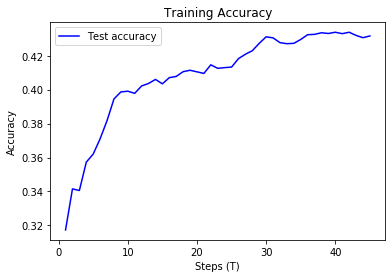

In [326]:
evalutaion_scores=[]
for model in models_qbc_ve:
     test_accuracy = models_qbc_ve_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,model[1])
     evalutaion_scores.append(test_accuracy)

iterations = range(1, len(evalutaion_scores) + 1)

plt.plot(iterations, evalutaion_scores, 'b', label='Test accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.xlabel("Steps (T)")
plt.ylabel("Accuracy")

plt.show()

In [339]:
models_qbc_vse = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                     train_committee,query_by_committee_soft_vote_entropy, 
                                     max_size, batch)

(9340, 30)
(9340, 30)
(9281, 30)
(9281, 30)
(9221, 30)
(9221, 30)
(9162, 30)
(9162, 30)
(9106, 30)
(9106, 30)
(9049, 30)
(9049, 30)
(8994, 30)
(8994, 30)
(8938, 30)
(8938, 30)
(8884, 30)
(8884, 30)
(8827, 30)
(8827, 30)
(8772, 30)
(8772, 30)
(8716, 30)
(8716, 30)
(8665, 30)
(8665, 30)
(8613, 30)
(8613, 30)
(8559, 30)
(8559, 30)
(8508, 30)
(8508, 30)
(8457, 30)
(8457, 30)
(8403, 30)
(8403, 30)
(8353, 30)
(8353, 30)
(8303, 30)
(8303, 30)
(8253, 30)
(8253, 30)
(8202, 30)
(8202, 30)
(8150, 30)
(8150, 30)
(8099, 30)
(8099, 30)
(8051, 30)
(8051, 30)
(8001, 30)
(8001, 30)
(7950, 30)
(7950, 30)
(7903, 30)
(7903, 30)
(7855, 30)
(7855, 30)
(7806, 30)
(7806, 30)
(7760, 30)
(7760, 30)
(7715, 30)
(7715, 30)
(7665, 30)
(7665, 30)
(7623, 30)
(7623, 30)
(7577, 30)
(7577, 30)
(7532, 30)
(7532, 30)
(7493, 30)
(7493, 30)
(7452, 30)
(7452, 30)
(7400, 30)
(7400, 30)
(7360, 30)
(7360, 30)
(7314, 30)
(7314, 30)
(7278, 30)
(7278, 30)
(7244, 30)
(7244, 30)
(7208, 30)
(7208, 30)
(7167, 30)
(7167, 30)
(7130, 30)

KeyboardInterrupt: 

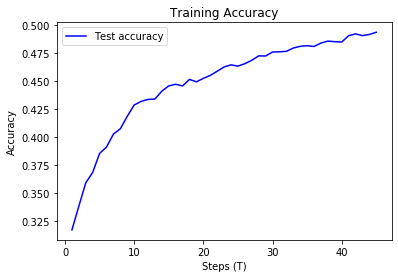

In [335]:
evalutaion_scores=[]
for model in models_qbc_vse:
     test_accuracy = models_qbc_ve_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,model[1])
     evalutaion_scores.append(test_accuracy)

iterations = range(1, len(evalutaion_scores) + 1)

plt.plot(iterations, evalutaion_scores, 'b', label='Test accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.xlabel("Steps (T)")
plt.ylabel("Accuracy")

plt.show()

## 5. Hierarchical sampling

In [20]:
## your code